# Invasive Ductal Cancer

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.config import list_physical_devices
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras import models, Sequential, layers
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [35]:
print("Number of GPUs: ", len(list_physical_devices('GPU')))

Number of GPUs:  0


# Load data

In [2]:
# Running locally
X = np.load('../data/X.npy')
y = np.load('../data/Y.npy')

In [4]:
X.shape

(5547, 50, 50, 3)

In [5]:
y.shape

(5547,)

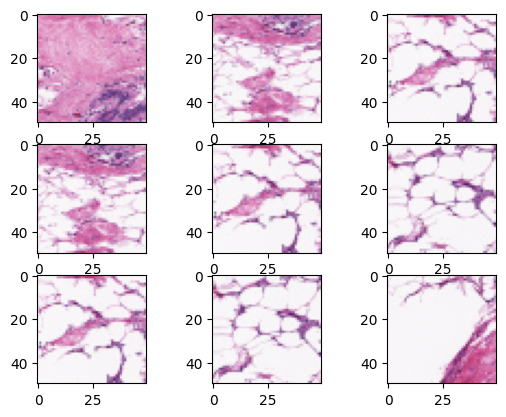

In [30]:
fig, axes = plt.subplots(3,3)
for row in range(3):
    for col in range(3):
        axes[row,col].imshow(X[row+col])

# Build model

## Data augmentation

In [6]:
X_scaled = X/255
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

# Instantiate image data generator
datagen = ImageDataGenerator(rotation_range=90, validation_split=0.2)

# Creates iterators for training images
train_images = datagen.flow(X_train, y_train, subset='training', batch_size=32)
val_images = datagen.flow(X_train, y_train, subset='validation', batch_size=32)

## CNN Model Evaluation

In [7]:
""" Model 1 (Based on Janowczyk and Madabhushi 2016)
Recall:             0.849642
Precision:          0.713426
F1 score:           0.775599
Balanced Accuracy:  0.751906
"""
def init_original_model1(learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(2,2), input_shape=(50, 50, 3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, kernel_size=(2,2), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, kernel_size=(2,2), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(16))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = Adagrad(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy', Recall(thresholds=0.35), Precision(thresholds=0.35)])
    return model

In [8]:
""" Final Model (Elizabeth's version)
Recall:             0.849642
Precision:          0.729508
F1 score:           0.785005
Balanced Accuracy:  0.765207
"""

def init_model(learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Conv2D(100, kernel_size=(3,3), input_shape=(50, 50, 3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(200, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(16))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = Adagrad(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy', Recall(thresholds=0.45), Precision(thresholds=0.45)])
    
    return model

In [9]:
model = init_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2022-10-29 15:01:07.245686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-29 15:01:07.245783: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-29 15:01:07.245831: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-9D92CCC): /proc/driver/nvidia/version does not exist
2022-10-29 15:01:07.246292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 conv2d (Conv2D)             (None, 48, 48, 100)       2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 200)       180200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 200)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 24200)             0         
                                                                 
 dense (Dense)               (None, 16)                387216    
                                                                 
 dropout (Dropout)           (None, 16)                0         
          

In [ ]:
# Training
model = init_model()
mc = ModelCheckpoint(filepath='data/checkpoints/{epoch:02d}-{val_loss:.2f}.h5', 
                     monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(train_images,
          validation_data=val_images,          
          epochs=1000,
          batch_size=64, 
          verbose=1,
          callbacks=mc)

# Evaluate model

In [25]:
y_pred = model.predict(X_test)
model.evaluate(X_test, y_test)

53/53 [==============================] - 4s 73ms/step - loss: 0.5028 - accuracy: 0.7646 - recall_1: 0.8353 - precision_1: 0.7384


[0.5028187036514282, 0.764564573764801, 0.8353222012519836, 0.7383966445922852]

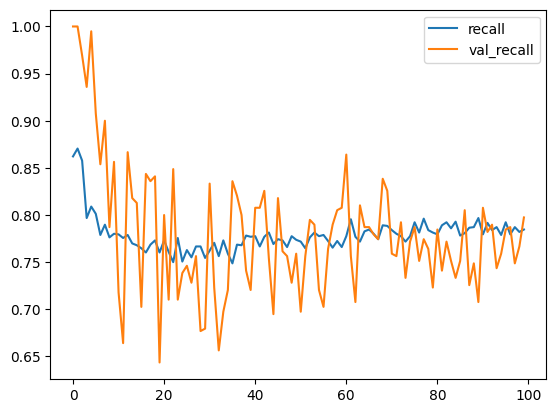

In [26]:
plt.plot(history.history['recall_1'], label='recall')
plt.plot(history.history['val_recall_1'], label='val_recall')
plt.legend()

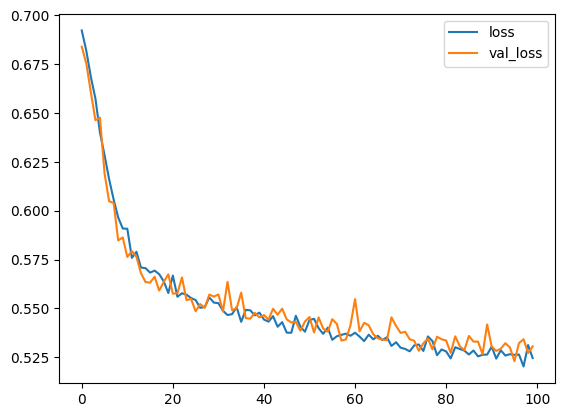

In [27]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

## Precision Recall Curve

In [15]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.5033033  0.50360577 0.5039086  0.50421179 0.50451535]
recall- [1. 1. 1. 1. 1.]
threshold- [0.04312778 0.05963376 0.0761065  0.07621722 0.07660956]


In [16]:
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})
scores.head()

,threshold,precision,recall
0,0.043128,0.503303,1.0
1,0.059634,0.503606,1.0
2,0.076106,0.503909,1.0
3,0.076217,0.504212,1.0
4,0.076610,0.504515,1.0


Text(0.5, 0, 'recall')

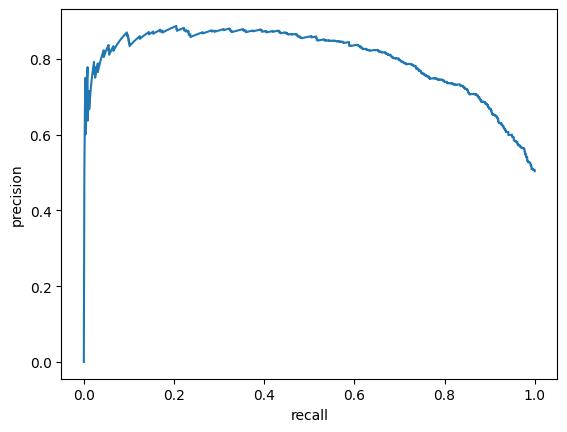

In [17]:
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [18]:
# Find threshold that guarantees 0.85 recall score
threshold = scores[scores['recall'] >= 0.85].threshold.max()
threshold

0.46764505

## Calculate model metrics

In [19]:
from sklearn.metrics import balanced_accuracy_score

In [20]:
def binary_predict(y_pred, custom_threshold=0.45):
    return (y_pred > custom_threshold).astype(int)

updated_preds = binary_predict(y_pred, custom_threshold=threshold)

print(f'Recall:             {recall_score(y_test, updated_preds)}')
print(f'Precision:          {precision_score(y_test, updated_preds)}')
print(f'F1 score:           {f1_score(y_test, updated_preds)}')
print(f'Balanced Accuracy:  {balanced_accuracy_score(y_test, updated_preds)}')

Recall:             0.8496420047732697
Precision:          0.717741935483871
F1 score:           0.7781420765027323
Balanced Accuracy:  0.75553442439389


# Save model

In [36]:
model.save('../data/models/modelV1')

INFO:tensorflow:Assets written to: ../data/models/modelV1/assets


INFO:tensorflow:Assets written to: ../data/models/modelV1/assets


In [37]:
model = load_model('../data/models/modelV1')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 100)       2800      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 100)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 200)       180200    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 200)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 24200)             0         
                                                                 
 dense_2 (Dense)             (None, 16)               